In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
print(f"CUDA available: {torch.cuda.is_available()}")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd")
OUTPUT_PDB = base_path / Path('predicted_structures')
CLEAN_DF_PATH = base_path / Path('subset_1.tsv')
RESULTS_PATH = base_path / Path('results.tsv')

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [3]:
len(os.listdir(OUTPUT_PDB))

254182

# Dataset

In [4]:
df_clean = pd.read_csv(CLEAN_DF_PATH, sep="\t")
results_old = pd.read_csv(RESULTS_PATH, sep="\t")
df_clean

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A8A1V5V2,MSTICGYRTIHILYIWYFTFNTVHTTINTTGITTFTVVFILYNTRHIIQNLIFTNTILTIPAEITMFSIRTPIFKFSHGRRIRPWYNLFRIQDGKG...,272,NaN,NaN,NaN,NaN,NaN,NaN,24.365400,NaN
1,A0A1X9T5E4,MVLNVLVAFVSIGFLHTKAQIVCMPDLPGTALDSTTEPNSEMSYQYGPVALRYRYAALNTSVCTHIPTYPSVLTQLVKIASRDSHGIVIGDVMGDT...,347,NaN,NaN,NaN,NaN,NaN,NaN,24.872775,NaN
2,A0A3G5AAX1,MGQFHYFQKMSTSHESSSEFKNVMFCYNKVAPQPNSKCYNKVPPQANLKVPQQAGTTSEFENVTTRWDHKRIQKSYNKVAPQANSKMLQQSGTTRE...,154,NaN,NaN,NaN,NaN,NaN,NaN,25.188144,NaN
3,A0A0C5KMH0,MEPERSTPMPSIPLLNRLGLARRGRGEERAGPTMPAQAQEPQKVPLLIKAARHFKSLLVQTEPERPETIPTIPELNYPALYTRYPVMKTVTKTTDA...,384,NaN,NaN,NaN,NaN,NaN,NaN,25.249915,NaN
4,A0A8S5R5U9,MLRWCMWASLCAESGVFGVELHDVLRVHATGFQLLHHGLKERGAGHILDQLLRGEAGGVVEGFLADVLSVAGGGPGLLLLKGGVLNVVDQHGLDTG...,384,NaN,NaN,NaN,NaN,NaN,NaN,25.339497,NaN
...,...,...,...,...,...,...,...,...,...,...,...
184544,I1V1M2,MTEELVNHLFEAIVAENVKRATANMAEPYNHSVYKFHEDRIDRLVTTLADGNEALRDQFYEALFDITWDGVAWAKKVFAEISRDIAEG,88,NaN,NaN,NaN,NaN,NaN,NaN,97.375280,NaN
184545,A0A6J7WXQ6,MKLAVTDLGFDGIETVADKLQEYGIEYIEVIPTKIKPYYALSQTDMVMYKDILADYNLKPYSFLSLFYGIDIKDLRPTDIILTQFNTLINYAKAVG...,250,NaN,NaN,NaN,NaN,NaN,NaN,97.432516,NaN
184546,A0A6J5SK54,MKTHIITKEQLDSNNNYIGKIDVSSFDGTLKAGSGLGIIRFTSIRVTGSIIFEAGSGIKAGSGIEAGWGIEAGWGIEAGWGIEAGNGIKAGNGIKA...,246,NaN,NaN,NaN,NaN,NaN,NaN,97.444731,NaN
184547,A0A8S5SFL1,MKALAFDRIAVLTAKGLPDRASYIAAGDLCQIGEKTAAGLWPVTYPTKKGQKTRWVRSLKGFLVNQNHFARISYPAKGYEKATIKSSGCGVCSAII...,243,NaN,NaN,NaN,NaN,NaN,NaN,97.578114,NaN


In [5]:
results = pd.DataFrame(columns=df_clean.columns)
for file in os.listdir(base_path):
    if file.startswith("results_"):
        temp_df = pd.read_csv(base_path / file, sep="\t")
        results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)
results

/tmp/ipykernel_3633931/1546108485.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)


,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A2P0XMJ6,ATPHSWLFENESSETTLRRWLTTLAHLKELGSFGEEVYQFDTKQVEKFGPQGKVPPVSEGLETLEDSYSANEPDMWLPANYEEQCAKLAAILFGQE...,275,NaN,78.899287,0.82977,NaN,0.822516,NaN,86.908455,5.290520
1,A0A060AH21,MKMQSIVQRYENDITVEVHADKIEIQTWRMYMANFAPYKLYDEDFIWEVSLQKAIDLPTEILYNDFVMTTEYAMTFADFAKIMQRARVGITCLIH,95,73.799157,32.351623,0.53149,0.92151,0.510320,0.898711,86.908478,36.787787
2,A0A8S5M9T9,MGLKKTNYEVKDYGVTLPEAYAVITKLEIEGDNGRAEFSVQASPRANCFNLQSYERHFVNFKFTDRTKNPFEAAYLAAKETRKGEQFGREIEYKMP...,108,76.842836,57.709989,0.74308,0.87116,0.729367,0.883431,86.909271,36.595681
3,A0A481V8D8,MTTDQASIELDTPRRYAVRYEVFNDGDWEIVTDTIEADRVLPVGMSVCWHNTTTGASLVVSDEQLIASWTEEVSSRD,77,NaN,79.472977,0.87024,NaN,0.937222,NaN,86.909293,0.897346
4,A0A8D9PFK9,MQFLITILRTETIMIVLNRKHIRQNLQKWARYTR,34,70.949367,53.233567,0.48039,0.92108,0.832938,0.998431,86.909500,36.830692
...,...,...,...,...,...,...,...,...,...,...,...
138328,A0A345MUA0,MVLRYARKGKKGRKATRKPKMSFDKRVLSVINKQRELKVAVITGTEPINGTITGTDLQQILPDIAQADGEFNRDGNEITLKKIIVRGWITQTFPND...,246,NaN,79.033815,0.80307,NaN,0.795426,NaN,85.524595,3.557342
138329,A0A6J5PCF8,MGKFVQIKAATNNVEYVPVREIYRIVYAPDHNEYTLVMRDGESYTAYPVDVARLLDNDR,59,NaN,80.789442,0.88293,NaN,0.890665,NaN,85.524690,0.868444
138330,A0A077EKP3,MFREIGDFVDRFVPHLIYIYLMVLCAFLCLYYIQQHRRIREQHRYDLDQHIKVSVIAAESDHKP,64,NaN,77.374774,0.89571,NaN,0.998721,NaN,85.524702,0.871988
138331,A0A8F6UA82,FWKPKEVRETLLQSLISKFLTTKAAMSGSTVMRQSQSTKSFHNSVVGAEDNFEVTRGTRLTASLYYHQAMAFGNIVLDPSHHDFSSYIVHKDQVGN...,243,57.228116,51.470051,0.67861,0.65357,0.520099,0.527140,85.524772,98.813444


In [7]:
results.pLDDT_after.value_counts()

pLDDT_after
74.490989    2
36.532941    2
53.060204    2
73.799157    1
47.506585    1
            ..
60.403831    1
65.804991    1
41.232966    1
58.375232    1
57.228116    1
Name: count, Length: 91876, dtype: int64

In [8]:
df = pd.concat([results_old, results], ignore_index=True)
df.shape[0], df.drop_duplicates('id').shape[0]

(255585, 149986)

In [9]:
df = df.drop_duplicates('id').reset_index(drop=True).sort_values('plddt_AlphaFold')
df.to_csv(RESULTS_PATH, sep="\t", index=False)

In [10]:
df_clean = df_clean[~df_clean.id.isin(df.id)]
df_clean.to_csv(CLEAN_DF_PATH, sep="\t", index=False)
df_clean.shape[0]

151815

In [9]:
df.query("pLDDT_after.notna() and pLDDT_after > plddt_AlphaFold")

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
1,A7ITD6,MRYDADTFPDAITFPNISVSKVLGTTPVTFEAFPEKYAAYILPVITIEFAIALPATMFPAVKKSVSTFPGADTFPTISMAAADGNVCVTSVRKNPF...,248,33.812316,24.619030,0.27418,0.18235,0.577954,0.596780,24.878686,100.703798
3,A0A6J5NU54,MNVEPFFRIAAGVTVRPEIPNATGSYQIATEPGGKTSTNFPGASRVVSGKFWPLNANGATISASPTNLLRLALDPLSTTTYYAHENWVCYGGWNTS...,223,46.954555,33.182055,0.25954,0.27844,0.492440,0.450770,25.646603,86.150285
6,K4K8N6,MTHILCICVSGFTKYYISCVKTTKNENDNFHSFRDFSSFPRLYRASSSRFCGVYGELENCPRQDPAVDHACVSQWDNRPCSLGTRNGPQTCTKTQS...,263,42.478695,25.954687,0.22361,0.24932,0.518755,0.494039,26.062917,124.994668
115592,A0A0P0YNH1,MSCASFWGSDPSLRRAASSVANSSLDLVISNKFVELIYVSIAASTPQIERRLVGRAESLKKFRIPDDVLSNHGPEIGASADLCEILEFTIIILIII...,290,27.248354,26.769425,0.24014,0.23590,0.463987,0.455578,26.189081,142.149755
7,A0A1C3NF07,MYVSKAPFGSVERMPSEGNYTFTFASRSVFSIPCYWLWTVTKSNDEPRPVRIPVFSVASNCFLSDVLFMTSKERYSPVKDFKTYPRLGVMDYVLVH...,238,35.757368,26.871811,NaN,NaN,NaN,NaN,26.226120,NaN
...,...,...,...,...,...,...,...,...,...,...,...
92013,A0A6J5T867,MEAIKYEISYDNQGNWETLGGIFYDTPFLAECALMIHWKELDILQQDYKMDNYQINKIDL,60,87.484713,69.531446,0.94150,0.94970,0.946389,0.955106,86.627228,37.861083
92046,A0A075TDU6,TGGTATISTSASRTRSYTWNGVAGSGGTETENGSPALSKVSGSGDWTSPKVTYGNNTSTSGKSTVIRATIDSTTKDITISQSAGAKQYSAWSAWTVNI,98,89.269801,39.105840,0.48114,0.86628,0.557243,0.966494,86.633333,37.633955
114856,A0A516L141,MNIDYTWDIVKVNYILKEGDLYYVIKNIEYKYTGIDSESGNSFVVPGNVDLKKPNPNSFIERENITKENYIQWLLNCGLSEHYLQQIIFFEIMQKNKI,98,87.311788,47.597908,0.52206,0.98056,0.582219,0.979697,87.046655,35.996332
96068,A0A6B9SPF7,MIREVIESFGFTRVTNSKYVKSDITLVLDSNLNITMMNQFSIRTIKVKDILGARDRIKNFLKHVGEL,67,88.021271,49.269963,0.69672,0.96162,0.669750,0.955307,87.285930,35.409429


In [10]:
df_clean

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time
0,A0A8A1V5V2,MSTICGYRTIHILYIWYFTFNTVHTTINTTGITTFTVVFILYNTRHIIQNLIFTNTILTIPAEITMFSIRTPIFKFSHGRRIRPWYNLFRIQDGKG...,272,NaN,NaN,NaN,NaN,NaN,NaN,24.365400,NaN
1,A0A1X9T5E4,MVLNVLVAFVSIGFLHTKAQIVCMPDLPGTALDSTTEPNSEMSYQYGPVALRYRYAALNTSVCTHIPTYPSVLTQLVKIASRDSHGIVIGDVMGDT...,347,NaN,NaN,NaN,NaN,NaN,NaN,24.872775,NaN
2,A0A3G5AAX1,MGQFHYFQKMSTSHESSSEFKNVMFCYNKVAPQPNSKCYNKVPPQANLKVPQQAGTTSEFENVTTRWDHKRIQKSYNKVAPQANSKMLQQSGTTRE...,154,NaN,NaN,NaN,NaN,NaN,NaN,25.188144,NaN
3,A0A0C5KMH0,MEPERSTPMPSIPLLNRLGLARRGRGEERAGPTMPAQAQEPQKVPLLIKAARHFKSLLVQTEPERPETIPTIPELNYPALYTRYPVMKTVTKTTDA...,384,NaN,NaN,NaN,NaN,NaN,NaN,25.249915,NaN
4,A0A8S5R5U9,MLRWCMWASLCAESGVFGVELHDVLRVHATGFQLLHHGLKERGAGHILDQLLRGEAGGVVEGFLADVLSVAGGGPGLLLLKGGVLNVVDQHGLDTG...,384,NaN,NaN,NaN,NaN,NaN,NaN,25.339497,NaN
...,...,...,...,...,...,...,...,...,...,...,...
187444,I1V1M2,MTEELVNHLFEAIVAENVKRATANMAEPYNHSVYKFHEDRIDRLVTTLADGNEALRDQFYEALFDITWDGVAWAKKVFAEISRDIAEG,88,NaN,NaN,NaN,NaN,NaN,NaN,97.375280,NaN
187445,A0A6J7WXQ6,MKLAVTDLGFDGIETVADKLQEYGIEYIEVIPTKIKPYYALSQTDMVMYKDILADYNLKPYSFLSLFYGIDIKDLRPTDIILTQFNTLINYAKAVG...,250,NaN,NaN,NaN,NaN,NaN,NaN,97.432516,NaN
187446,A0A6J5SK54,MKTHIITKEQLDSNNNYIGKIDVSSFDGTLKAGSGLGIIRFTSIRVTGSIIFEAGSGIKAGSGIEAGWGIEAGWGIEAGWGIEAGNGIKAGNGIKA...,246,NaN,NaN,NaN,NaN,NaN,NaN,97.444731,NaN
187447,A0A8S5SFL1,MKALAFDRIAVLTAKGLPDRASYIAAGDLCQIGEKTAAGLWPVTYPTKKGQKTRWVRSLKGFLVNQNHFARISYPAKGYEKATIKSSGCGVCSAII...,243,NaN,NaN,NaN,NaN,NaN,NaN,97.578114,NaN


## Plots

In [1]:
sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
sns.kdeplot(sub_df['plddt_AlphaFold'], label='AlphaFold', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

NameError: name 'df' is not defined

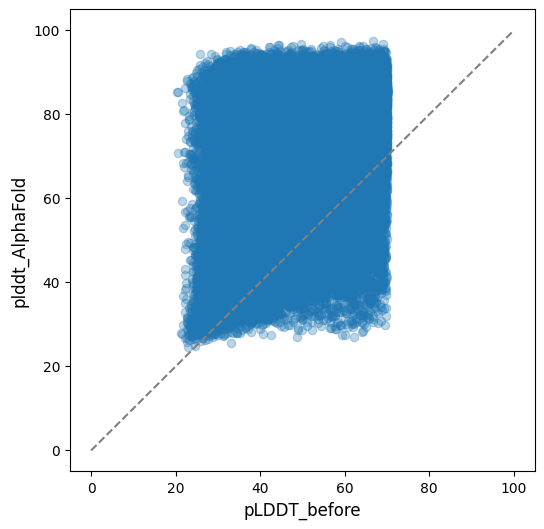

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_before'], sub_df['plddt_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_before", fontsize=12)
ax.set_ylabel("plddt_AlphaFold", fontsize=12)
plt.show()

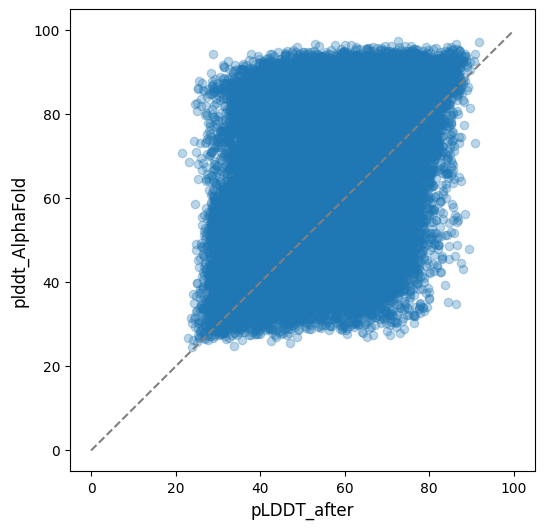

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_after'], sub_df['plddt_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_after", fontsize=12)
ax.set_ylabel("plddt_AlphaFold", fontsize=12)
plt.show()

nan nan


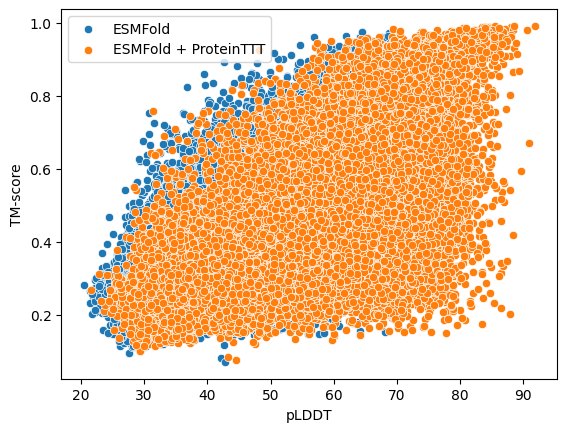

In [26]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['tm_score_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], y=sub_df['tm_score_after'])[0, 1])
sns.scatterplot(data=sub_df, x='pLDDT_before', y='tm_score_before', label='ESMFold')
sns.scatterplot(data=sub_df, x='pLDDT_after', y='tm_score_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

nan nan


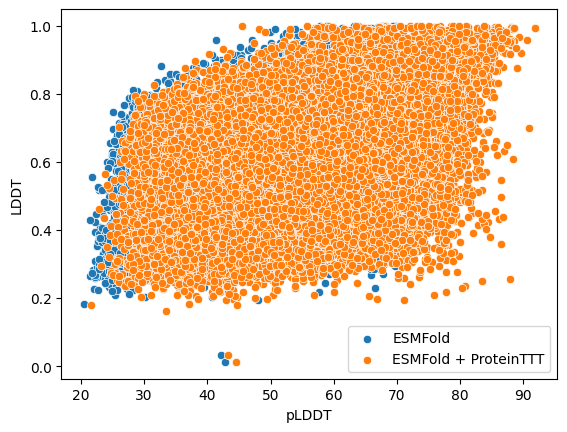

In [27]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['lddt_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], sub_df['lddt_after'])[0, 1])
sns.scatterplot(sub_df, x='pLDDT_before', y='lddt_before', label='ESMFold')
sns.scatterplot(sub_df, x='pLDDT_after', y='lddt_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('LDDT')
plt.legend()

In [28]:
sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['tm_score_difference']])
sns.swarmplot(data=sub_df[['tm_score_difference']], color=".25")
plt.ylabel('tm_score_difference')
# plt.xticks([0, 1], ['tm_score_difference'])
plt.show()

/tmp/ipykernel_1306274/709628841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1472f54f05e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [14]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    78680.000000
 mean        49.027842
 std         12.158377
 min         20.331049
 25%         38.786255
 50%         48.721753
 75%         59.705194
 max         69.998968
 Name: pLDDT_before, dtype: float64,
 count    78680.000000
 mean        57.656607
 std         12.239061
 min         21.599748
 25%         48.463769
 50%         58.670126
 75%         67.542062
 max         91.803119
 Name: pLDDT_after, dtype: float64)

In [ ]:
sub_df